# K-Segmentation For Sequence Data
Author: Rafael Zamora

---

## Overview

This project contains a Python implementation of the Bellman k-segmentation
algorithm as described in this [blog](http://homepages.spa.umn.edu/~willmert/science/ksegments/).
The algorithm generates a segmented constant-line fit to a data series, which
is useful in finding unique clusters along sequentially ordered data.

### Implementation
The following is the code implementing the k-segmentation algorithm. The function `regress_ksegments` is used to perform the segmentation and takes in arguments `series`, `weights`, and `k`. `series` is the 1D matrix of values that will be segmented. `weights` are how each element of the series should be weighed and this can be used to tune the segmentation if needed. `k` is the number of segments that will be produced.

In [1]:
import numpy as np

def prepare_ksegments(series,weights):
    '''
    '''
    N = len(series)
    #
    wgts = np.diag(weights)
    wsum = np.diag(weights*series)
    sqrs = np.diag(weights*series*series)

    dists = np.zeros((N,N))
    means = np.diag(series)

    for i in range(N):
        for j in range(N-i):
            r = i+j
            wgts[j,r] = wgts[j,r-1] + wgts[r,r]
            wsum[j,r] = wsum[j,r-1] + wsum[r,r]
            sqrs[j,r] = sqrs[j,r-1] + sqrs[r,r]
            means[j,r] = wsum[j,r] / wgts[j,r]
            dists[j,r] = sqrs[j,r] - means[j,r]*wsum[j,r]

    return dists, means

def regress_ksegments(series, weights, k):
    '''
    '''
    N = len(series)

    dists, means = prepare_ksegments(series, weights)

    k_seg_dist = np.zeros((k,N+1))
    k_seg_path = np.zeros((k,N))
    k_seg_dist[0,1:] = dists[0,:]

    k_seg_path[0,:] = 0
    for i in range(k):
        k_seg_path[i,:] = i

    for i in range(1,k):
        for j in range(i,N):
            choices = k_seg_dist[i-1, :j] + dists[:j, j]
            best_index = np.argmin(choices)
            best_val = np.min(choices)

            k_seg_path[i,j] = best_index
            k_seg_dist[i,j+1] = best_val

    reg = np.zeros(series.shape)
    rhs = len(reg)-1
    for i in reversed(range(k)):
        lhs = k_seg_path[i,rhs]
        reg[int(lhs):rhs] = means[int(lhs),rhs]
        rhs = int(lhs)

    return reg

### Testing Bellman K-Segmentation

Here, we generate a sine wave and then apply the segmentation algorithm. Its currently set to generate a sine wave which cycles 5 times. We then segment the wave into 10 segments to match each peak and valley.

In [28]:
# Generate Sine Wave
Fs = 100
f = 5
sample = 100
x = np.arange(sample)
y = np.sin(2 * np.pi * f * x / Fs)

In [29]:
# Perform K-Segmentation
k = 10
y_segs = regress_ksegments(y, np.ones(x.shape), 10)

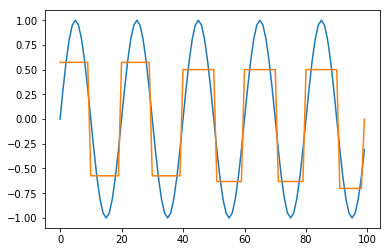

In [30]:
%matplotlib inline
from matplotlib import pyplot as plt

# Plot Sine Wave and Segmentation
plt.plot(x,y)
plt.plot(x,y_segs)
plt.show()